## Leaf biomass allometries 

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import rioxarray as rx
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

#import functions_py.fates_xarray_functions as fa

from cartopy.io.shapereader import Reader
import shapefile
from shapely.geometry import shape, Point, LinearRing

import regionmask

from shapely.geometry import MultiPolygon, Polygon

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def d2bl (d, p1, p2) :
    bl = (p1 * d ** p2) / 2.0
    return bl

In [3]:
realms = ['Americas', 'Africa', 'Asia']
dbh = np.arange(1,240,1)

### TUNE THESE !!!
bl_p0s = [0.05213, 0.1291, 0.03914, 0.1006, 0.0543, 0.0217]

### To ensure we don't accidently mess up the order assign them now
ca_ps_continent = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/ca_continent_ps.csv')
bl_p1s = [ca_ps_continent.American_rf[1], ca_ps_continent.African_rf[1], ca_ps_continent.Asian_rf[1], 
          ca_ps_continent.American_df[1], ca_ps_continent.African_s[1], ca_ps_continent.Asian_rf[1]]
print(bl_p1s)

[1.5018686384724127, 1.3037202724270962, 1.5337679957389716, 1.0831910055484035, 1.4977035089163393, 1.5337679957389716]


Text(0.02, 0.5, 'Leaf Biomass (kg C)')

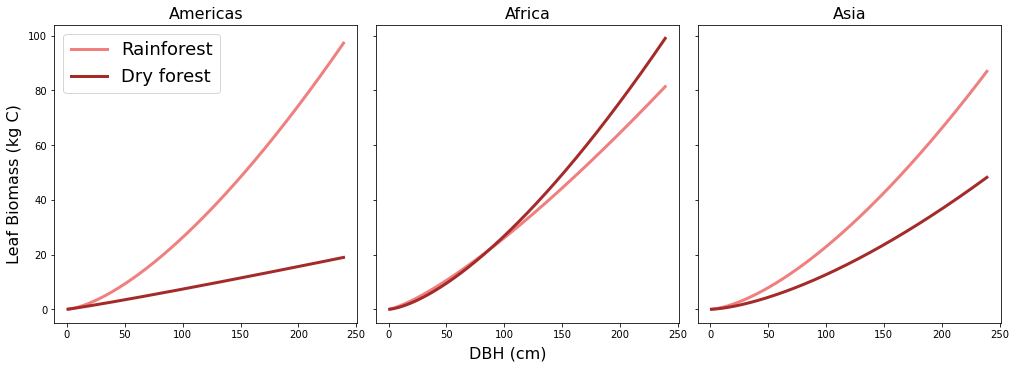

In [4]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,5), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms)): 
    realm = realms[i]

    curve_rf = [d2bl(d, bl_p0s[i], bl_p1s[i])  for  d  in dbh]
    curve_df = [d2bl(d, bl_p0s[i+3], bl_p1s[i+3]) for d in dbh]

    axs[i].plot(dbh, curve_rf, color='lightcoral', linewidth=3.0, label = 'Rainforest')
    axs[i].plot(dbh, curve_df, color='brown', linewidth=3.0, label = 'Dry forest')
    axs[i].set_title(realm,  fontsize=16)

axs[0].legend(fontsize=18)    
 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Leaf Biomass (kg C)', fontsize=16)

In [5]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

In [6]:
realms = ['Americas', 'Africa', 'Asia']
dbh = np.arange(1,240,1)

ca_p0s = [ca_ps_continent.American_rf[0], ca_ps_continent.African_rf[0], ca_ps_continent.Asian_rf[0], 
          ca_ps_continent.American_df[0], ca_ps_continent.African_s[0], ca_ps_continent.Asian_rf[0]]
ca_p1s = [ca_ps_continent.American_rf[1], ca_ps_continent.African_rf[1], ca_ps_continent.Asian_rf[1], 
          ca_ps_continent.American_df[1], ca_ps_continent.African_s[1], ca_ps_continent.Asian_rf[1]]

Text(0.02, 0.5, 'Crown Area')

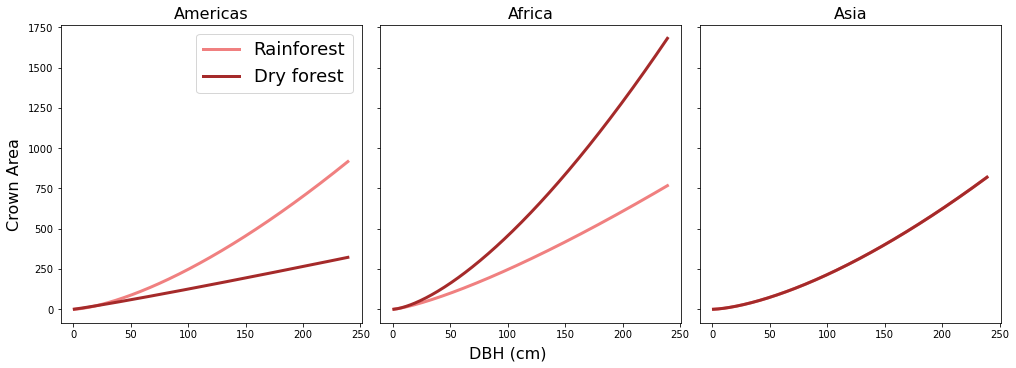

In [7]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,5), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms)): 
    realm = realms[i]

    curve_rf = [d2ca(d, ca_p0s[i], ca_p1s[i])  for  d  in dbh]
    curve_df = [d2ca(d, ca_p0s[i+3], ca_p1s[i+3]) for d in dbh]

    axs[i].plot(dbh, curve_rf, color='lightcoral', linewidth=3.0, label = 'Rainforest')
    axs[i].plot(dbh, curve_df, color='brown', linewidth=3.0, label = 'Dry forest')
    axs[i].set_title(realm,  fontsize=16)

axs[0].legend(fontsize=18)    
 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown Area', fontsize=16)

## LAI 

In [8]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn

In [9]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai

In [10]:
vcmax25top  = [53.142, 53.142, 53.142, 53.142, 53.142, 53.142,]
nitr_stoich  = [0.033, 0.033, 0.033, 0.04, 0.04, 0.04]
slatop = [0.024, 0.024, 0.024, 0.03, 0.03, 0.03]
slamax= [0.03, 0.03, 0.03, 0.05, 0.05, 0.053]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0

diff =  [a - b for a,b in zip(ca_p1s, bl_p1s)]

In [11]:
pftnames = ['broadleaf_evergreen_tropical_americas_tree', 'broadleaf_evergreen_tropical_african_tree', 
            'broadleaf_evergreen_tropical_asian_tree','broadleaf_hydrodecid_tropical_americas_tree',
            'broadleaf_hydrodecid_tropical_african_tree', 'broadleaf_hydrodecid_tropical_asian_tree',
        'c4_grass']

In [12]:
bl_p0s = [0.05213, 0.1291, 0.03914, 0.099, 0.0534, 0.0213]


''

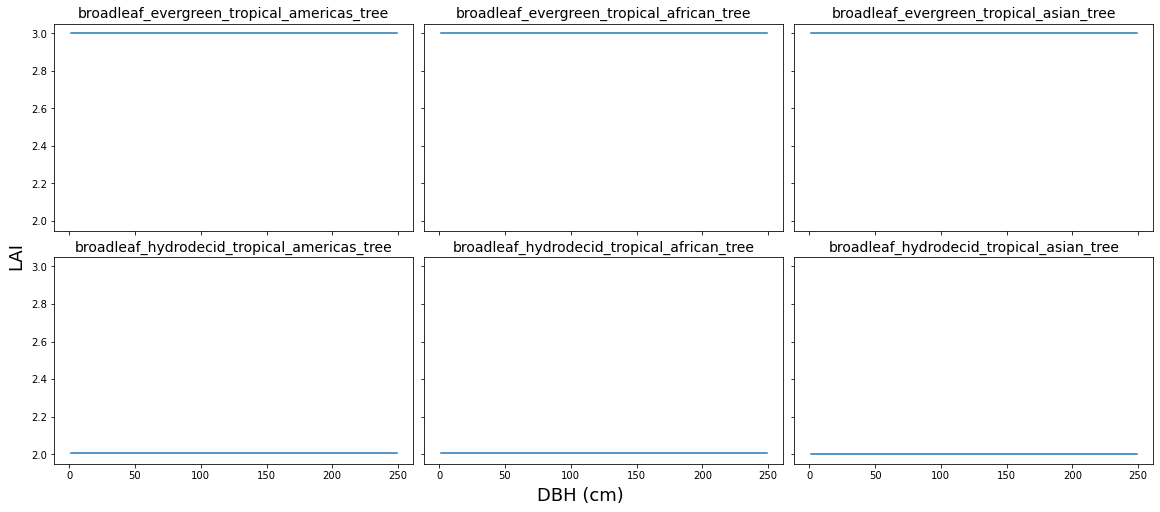

In [13]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 6) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    bleaf_curve = [d2bl(d, bl_p0s[pf], bl_p1s[pf])  for  d  in dbh]
    
    # calculate crown area
    ca_curve = [d2ca(d, ca_p0s[pf],  ca_p1s[pf])  for  d  in dbh]
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(bleaf_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)
    #axs[pf].set_ylim(1.9, 2.1)
    

fig2.supylabel('LAI', fontsize=18)
fig2.supxlabel('DBH (cm)', fontsize=18)  

;

In [14]:
bl_continent_ps = pd.DataFrame([bl_p0s])
bl_continent_ps.columns = ['American_rf','African_rf','Asian_rf','American_df','African_s','Asian_df']
bl_continent_ps

,American_rf,African_rf,Asian_rf,American_df,African_s,Asian_df
0,0.05213,0.1291,0.03914,0.099,0.0534,0.0213


In [15]:
bl_continent_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/bl_continent_ps.csv', index=False)

## pantropical PFTs - also tune these parameters 

In [16]:
ca_ps_pantropical = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/ca_pantropical_ps.csv')
ca_ps_pantropical

,rainforest,dry_savanna
0,0.222679,0.288960
1,1.514928,1.593351


In [17]:
### Tune these 
bl_p0s = [0.0472, 0.034]

# These get set from the crown area 
ca_ps_pantropical = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/ca_pantropical_ps.csv')
bl_p1s = [ca_ps_pantropical.rainforest[1], ca_ps_pantropical.dry_savanna[1]]


Text(0.02, 0.5, 'Leaf Biomass (kg C)')

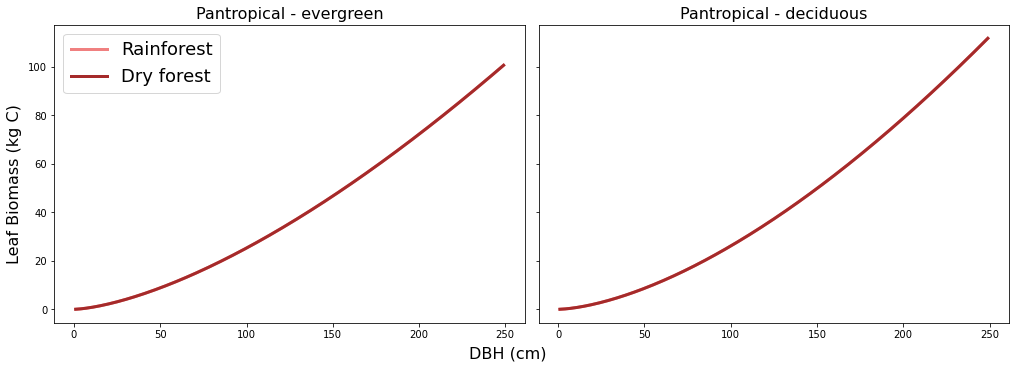

In [18]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,2): 
    
    curve_rf = [d2bl(d, bl_p0s[i], bl_p1s[i])  for  d  in dbh]
    curve_df = [d2bl(d, bl_p0s[i], bl_p1s[i]) for d in dbh]

    axs[i].plot(dbh, curve_rf, color='lightcoral', linewidth=3.0, label = 'Rainforest')
    axs[i].plot(dbh, curve_df, color='brown', linewidth=3.0, label = 'Dry forest')
    
axs[0].legend(fontsize=18)  

axs[0].set_title('Pantropical - evergreen',  fontsize=16)
axs[1].set_title('Pantropical - deciduous',  fontsize=16)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Leaf Biomass (kg C)', fontsize=16)

In [19]:
ca_p0s = [ca_ps_pantropical.rainforest[0], ca_ps_pantropical.dry_savanna[0]]
ca_p1s = [ca_ps_pantropical.rainforest[1], ca_ps_pantropical.dry_savanna[1]]



Text(0.02, 0.5, 'Crown Area')

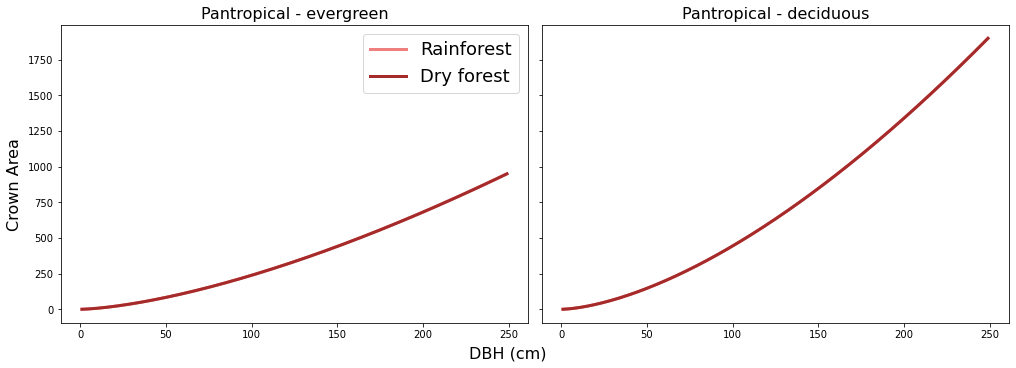

In [20]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,2): 
    curve_rf = [d2ca(d, ca_p0s[i], ca_p1s[i])  for  d  in dbh]
    curve_df = [d2ca(d, ca_p0s[i], ca_p1s[i]) for d in dbh]

    axs[i].plot(dbh, curve_rf, color='lightcoral', linewidth=3.0, label = 'Rainforest')
    axs[i].plot(dbh, curve_df, color='brown', linewidth=3.0, label = 'Dry forest')

axs[0].legend(fontsize=18)    
axs[0].set_title('Pantropical - evergreen',  fontsize=16)
axs[1].set_title('Pantropical - deciduous',  fontsize=16)

 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown Area', fontsize=16)

## LAI 

In [21]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn

In [22]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai

In [23]:
vcmax25top  = [53.142, 53.142]
nitr_stoich  = [0.033, 0.04]
slatop = [0.024, 0.03]
slamax= [0.03, 0.05]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0

diff =  [a - b for a,b in zip(ca_p1s, bl_p1s)]

In [24]:
bl_p0s = [0.0472, 0.0334]

''

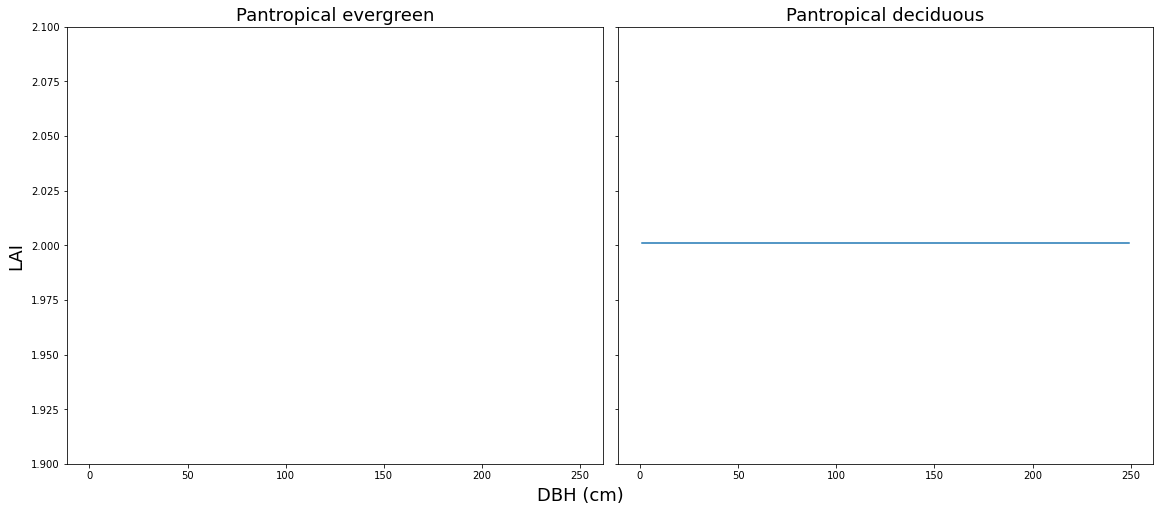

In [25]:
fig2, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 2) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    bleaf_curve = [d2bl(d, bl_p0s[pf], bl_p1s[pf])  for  d  in dbh]
    
    # calculate crown area
    ca_curve = [d2ca(d, ca_p0s[pf],  ca_p1s[pf])  for  d  in dbh]
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(bleaf_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    
    axs[pf].set_ylim(1.9, 2.1)
    
axs[0].set_title('Pantropical evergreen', fontsize=18)
axs[1].set_title('Pantropical deciduous', fontsize=18)
fig2.supylabel('LAI', fontsize=18)
fig2.supxlabel('DBH (cm)', fontsize=18)  

;

In [26]:
bl_pantropical_ps = pd.DataFrame([bl_p0s])
bl_pantropical_ps.columns = ['evergreen','deciduous',]
bl_pantropical_ps

,evergreen,deciduous
0,0.0472,0.0334


In [27]:
bl_pantropical_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/bl_pantropical_ps.csv', index=False)